In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [ ]:
df = pd.read_excel('/content/Online Retail.xlsx')
print(f"✓ Data loaded successfully!")
print(f"  - Total records: {len(df):,}")
print(f"  - Total columns: {len(df.columns)}")
print(f"  - Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

✓ Data loaded successfully!
  - Total records: 541,909
  - Total columns: 8
  - Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


DATA PREPROCESSING

In [ ]:
print("\n[STEP 2] DATA PREPROCESSING...")

# 3.1 Remove duplicates
initial_rows = len(df)
df = df.drop_duplicates()
print(f"✓ Removed {initial_rows - len(df):,} duplicate rows")

# 3.2 Handle missing values
print(f"✓ Missing values before cleaning:")
print(df.isnull().sum())

# Remove rows with missing CustomerID (can't analyze without customer info)
df = df[df['CustomerID'].notna()]
print(f"  - Removed rows with missing CustomerID")

# Remove rows with missing Description
df = df[df['Description'].notna()]
print(f"  - Removed rows with missing Description")

# 3.3 Remove cancelled transactions (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print(f"✓ Removed cancelled transactions")

# 3.4 Remove negative quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print(f"✓ Removed negative/zero quantities and prices")

# 3.5 Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 3.6 Remove outliers using IQR method
Q1 = df['TotalPrice'].quantile(0.25)
Q3 = df['TotalPrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['TotalPrice'] >= lower_bound) & (df['TotalPrice'] <= upper_bound)]
print(f"✓ Removed outliers using IQR method")

print(f"\n✓ Final dataset shape: {df.shape}")
print(f"  - Total records after cleaning: {len(df):,}")


[STEP 2] DATA PREPROCESSING...
✓ Removed 5,268 duplicate rows
✓ Missing values before cleaning:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64
  - Removed rows with missing CustomerID
  - Removed rows with missing Description
✓ Removed cancelled transactions
✓ Removed negative/zero quantities and prices
✓ Removed outliers using IQR method

✓ Final dataset shape: (361461, 9)
  - Total records after cleaning: 361,461


FEATURE ENGINEERING - RFM ANALYSIS

In [ ]:
print("RFM stands for:")
print("  - Recency: How recently a customer made a purchase")
print("  - Frequency: How often they purchase")
print("  - Monetary: How much money they spend")

# Set reference date (1 day after the last transaction)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"\nReference date for Recency calculation: {reference_date}")

# Calculate RFM metrics for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(f"\n✓ RFM metrics calculated for {len(rfm)} customers")
print("\nRFM Statistics:")
print(rfm.describe())

RFM stands for:
  - Recency: How recently a customer made a purchase
  - Frequency: How often they purchase
  - Monetary: How much money they spend

Reference date for Recency calculation: 2011-12-10 12:50:00

✓ RFM metrics calculated for 4194 customers

RFM Statistics:
         CustomerID      Recency    Frequency      Monetary
count   4194.000000  4194.000000  4194.000000   4194.000000
mean   15295.341440    92.563662     4.007153   1042.821770
std     1718.549024    99.724342     7.025316   2217.324037
min    12347.000000     1.000000     1.000000      1.900000
25%    13815.250000    18.000000     1.000000    223.082500
50%    15294.000000    51.000000     2.000000    494.580000
75%    16773.750000   144.000000     4.000000   1183.545000
max    18287.000000   374.000000   201.000000  89434.510000


DATA NORMALIZATION

In [ ]:
print("Using StandardScaler to normalize RFM features...")

# Create features for clustering
features = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print("✓ Data normalized successfully")
print("\nNormalized data statistics:")
print(features_scaled_df.describe())

Using StandardScaler to normalize RFM features...
✓ Data normalized successfully

Normalized data statistics:
            Recency     Frequency      Monetary
count  4.194000e+03  4.194000e+03  4.194000e+03
mean  -5.463759e-17 -1.694189e-17 -7.793268e-17
std    1.000119e+00  1.000119e+00  1.000119e+00
min   -9.182771e-01 -4.280963e-01 -4.695055e-01
25%   -7.477869e-01 -4.280963e-01 -3.697416e-01
50%   -4.168352e-01 -2.857370e-01 -2.472833e-01
75%    5.158467e-01 -1.018307e-03  6.347291e-02
max    2.822479e+00  2.804377e+01  3.986888e+01


DETERMINING OPTIMAL NUMBER OF CLUSTERS

✓ Elbow and Silhouette plots saved

✓ Optimal number of clusters based on Silhouette Score: 4


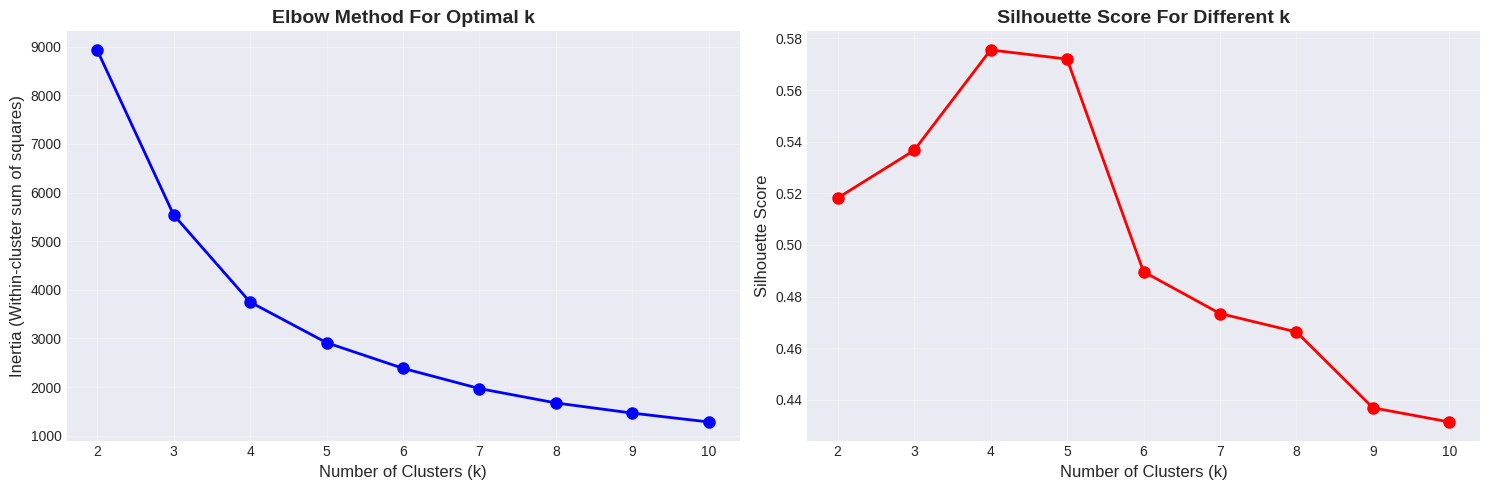

In [ ]:
# Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot Elbow Curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method For Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score For Different k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/elbow_silhouette.png', dpi=300, bbox_inches='tight')
print("✓ Elbow and Silhouette plots saved")

# Optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✓ Optimal number of clusters based on Silhouette Score: {optimal_k}")

K-MEANS CLUSTERING

In [ ]:
# Apply K-Means with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans_final.fit_predict(features_scaled)

print(f"✓ Clustering completed!")
print(f"\nCluster distribution:")
print(rfm['Cluster'].value_counts().sort_index())

✓ Clustering completed!

Cluster distribution:
Cluster
0    2843
1       5
2    1044
3     302
Name: count, dtype: int64


CLUSTER ANALYSIS

In [ ]:
# Calculate cluster statistics
cluster_stats = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)
cluster_stats.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']

print("\nCluster Characteristics:")
print(cluster_stats)

# Assign cluster names based on RFM characteristics
def name_cluster(row):
    if row['Avg_Recency'] < 50 and row['Avg_Monetary'] > 2000:
        return 'Champions'
    elif row['Avg_Recency'] < 50 and row['Avg_Monetary'] > 1000:
        return 'Loyal Customers'
    elif row['Avg_Recency'] > 100 and row['Avg_Monetary'] < 500:
        return 'Lost Customers'
    elif row['Avg_Frequency'] < 5 and row['Avg_Monetary'] < 500:
        return 'New Customers'
    else:
        return 'Potential Loyalists'

cluster_stats['Cluster_Name'] = cluster_stats.apply(name_cluster, axis=1)
print("\nCluster Names:")
print(cluster_stats[['Cluster_Name', 'Customer_Count']])


Cluster Characteristics:
         Avg_Recency  Avg_Frequency  Avg_Monetary  Customer_Count
Cluster                                                          
0              44.52           3.30        844.79            2843
1               2.40         123.00      44190.84               5
2             246.62           1.53        331.04            1044
3              13.75          17.23       4653.28             302

Cluster Names:
                Cluster_Name  Customer_Count
Cluster                                     
0        Potential Loyalists            2843
1                  Champions               5
2             Lost Customers            1044
3                  Champions             302


VISUALIZATION

✓ RFM distribution plots saved
✓ 3D scatter plot saved
✓ Cluster centers heatmap saved


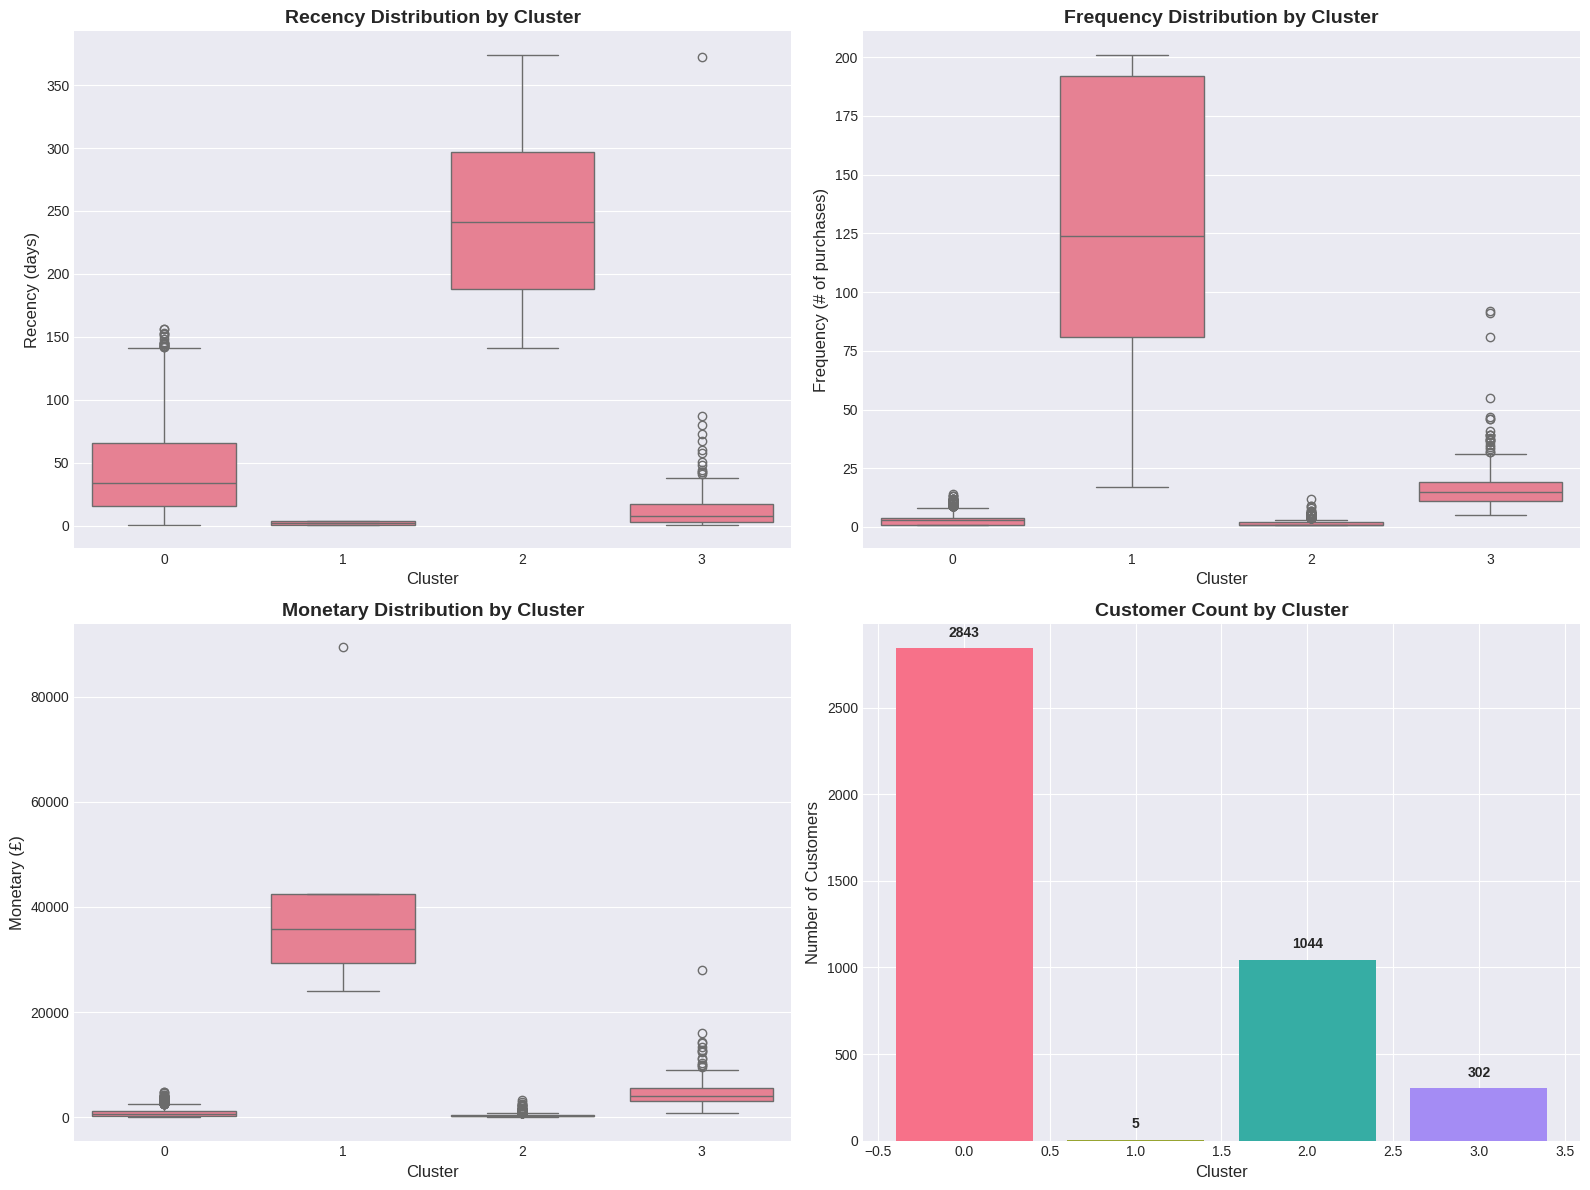

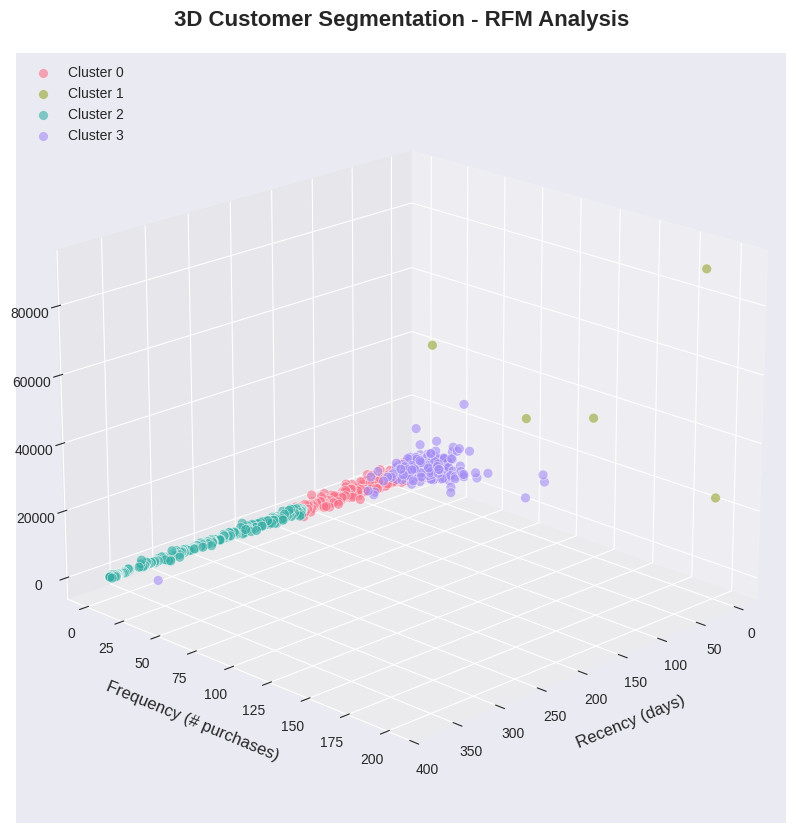

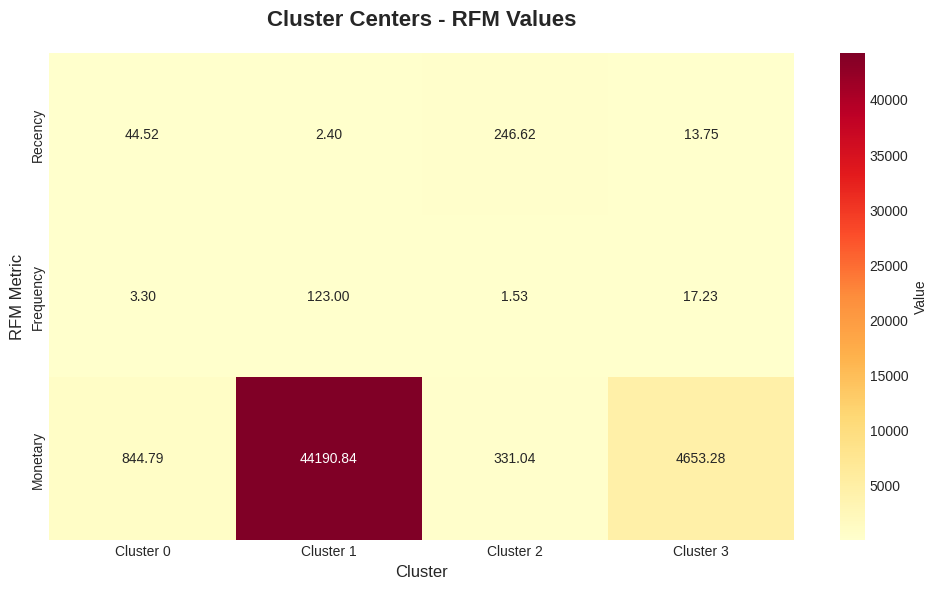

In [ ]:
# 9.1 RFM Distribution by Cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Recency by Cluster
sns.boxplot(data=rfm, x='Cluster', y='Recency', ax=axes[0, 0])
axes[0, 0].set_title('Recency Distribution by Cluster', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Cluster', fontsize=12)
axes[0, 0].set_ylabel('Recency (days)', fontsize=12)

# Frequency by Cluster
sns.boxplot(data=rfm, x='Cluster', y='Frequency', ax=axes[0, 1])
axes[0, 1].set_title('Frequency Distribution by Cluster', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('Frequency (# of purchases)', fontsize=12)

# Monetary by Cluster
sns.boxplot(data=rfm, x='Cluster', y='Monetary', ax=axes[1, 0])
axes[1, 0].set_title('Monetary Distribution by Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Monetary (£)', fontsize=12)

# Customer count by Cluster
cluster_counts = rfm['Cluster'].value_counts().sort_index()
axes[1, 1].bar(cluster_counts.index, cluster_counts.values, color=sns.color_palette("husl", optimal_k))
axes[1, 1].set_title('Customer Count by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Number of Customers', fontsize=12)
for i, v in enumerate(cluster_counts.values):
    axes[1, 1].text(i, v + 50, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/rfm_distribution.png', dpi=300, bbox_inches='tight')
print("✓ RFM distribution plots saved")

# 9.2 3D Scatter Plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette("husl", optimal_k)
for i in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == i]
    ax.scatter(cluster_data['Recency'],
               cluster_data['Frequency'],
               cluster_data['Monetary'],
               c=[colors[i]],
               label=f'Cluster {i}',
               s=50,
               alpha=0.6,
               edgecolors='w',
               linewidth=0.5)

ax.set_xlabel('Recency (days)', fontsize=12, labelpad=10)
ax.set_ylabel('Frequency (# purchases)', fontsize=12, labelpad=10)
ax.set_zlabel('Monetary (£)', fontsize=12, labelpad=10)
ax.set_title('3D Customer Segmentation - RFM Analysis', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.view_init(elev=20, azim=45)

plt.savefig('/content/3d_clusters.png', dpi=300, bbox_inches='tight')
print("✓ 3D scatter plot saved")

# 9.3 Cluster Centers Heatmap
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans_final.cluster_centers_),
    columns=['Recency', 'Frequency', 'Monetary']
)
centers.index = [f'Cluster {i}' for i in range(optimal_k)]

plt.figure(figsize=(10, 6))
sns.heatmap(centers.T, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Value'})
plt.title('Cluster Centers - RFM Values', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('RFM Metric', fontsize=12)
plt.tight_layout()
plt.savefig('/content/cluster_centers.png', dpi=300, bbox_inches='tight')
print("✓ Cluster centers heatmap saved")

MODEL EVALUATION

In [ ]:
# Calculate evaluation metrics
silhouette_avg = silhouette_score(features_scaled, rfm['Cluster'])
davies_bouldin = davies_bouldin_score(features_scaled, rfm['Cluster'])
calinski_harabasz = calinski_harabasz_score(features_scaled, rfm['Cluster'])

print("\nClustering Evaluation Metrics:")
print(f"  1. Silhouette Score: {silhouette_avg:.4f}")
print(f"     → Range: [-1, 1], Higher is better")
print(f"     → Interpretation: {silhouette_avg:.4f} indicates {'excellent' if silhouette_avg > 0.7 else 'good' if silhouette_avg > 0.5 else 'moderate'} cluster separation")
print(f"\n  2. Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"     → Range: [0, ∞], Lower is better")
print(f"     → Interpretation: {davies_bouldin:.4f} indicates {'excellent' if davies_bouldin < 0.5 else 'good' if davies_bouldin < 1.0 else 'moderate'} cluster quality")
print(f"\n  3. Calinski-Harabasz Score: {calinski_harabasz:.2f}")
print(f"     → Range: [0, ∞], Higher is better")
print(f"     → Interpretation: Higher values indicate better-defined clusters")



Clustering Evaluation Metrics:
  1. Silhouette Score: 0.5755
     → Range: [-1, 1], Higher is better
     → Interpretation: 0.5755 indicates good cluster separation

  2. Davies-Bouldin Index: 0.6623
     → Range: [0, ∞], Lower is better
     → Interpretation: 0.6623 indicates good cluster quality

  3. Calinski-Harabasz Score: 3290.62
     → Range: [0, ∞], Higher is better
     → Interpretation: Higher values indicate better-defined clusters


BUSINESS INSIGHTS & RECOMMENDATIONS

In [ ]:
# Calculate evaluation metrics
silhouette_avg = silhouette_score(features_scaled, rfm['Cluster'])
davies_bouldin = davies_bouldin_score(features_scaled, rfm['Cluster'])
calinski_harabasz = calinski_harabasz_score(features_scaled, rfm['Cluster'])

print("\nClustering Evaluation Metrics:")
print(f"  1. Silhouette Score: {silhouette_avg:.4f}")
print(f"     → Range: [-1, 1], Higher is better")
print(f"     → Interpretation: {silhouette_avg:.4f} indicates {'excellent' if silhouette_avg > 0.7 else 'good' if silhouette_avg > 0.5 else 'moderate'} cluster separation")
print(f"\n  2. Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"     → Range: [0, ∞], Lower is better")
print(f"     → Interpretation: {davies_bouldin:.4f} indicates {'excellent' if davies_bouldin < 0.5 else 'good' if davies_bouldin < 1.0 else 'moderate'} cluster quality")
print(f"\n  3. Calinski-Harabasz Score: {calinski_harabasz:.2f}")
print(f"     → Range: [0, ∞], Higher is better")
print(f"     → Interpretation: Higher values indicate better-defined clusters")



Clustering Evaluation Metrics:
  1. Silhouette Score: 0.5755
     → Range: [-1, 1], Higher is better
     → Interpretation: 0.5755 indicates good cluster separation

  2. Davies-Bouldin Index: 0.6623
     → Range: [0, ∞], Lower is better
     → Interpretation: 0.6623 indicates good cluster quality

  3. Calinski-Harabasz Score: 3290.62
     → Range: [0, ∞], Higher is better
     → Interpretation: Higher values indicate better-defined clusters


SAVE RESULTS

In [ ]:
print("\n[STEP 11] SAVING RESULTS...")

# Save RFM data with clusters
rfm_with_clusters = rfm.copy()
rfm_with_clusters.to_csv('/content/customer_segments.csv', index=False)
print("✓ Customer segments saved to 'customer_segments.csv'")

# Save cluster statistics
cluster_stats.to_csv('/content/cluster_statistics.csv')
print("✓ Cluster statistics saved to 'cluster_statistics.csv'")

# Save evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
    'Value': [silhouette_avg, davies_bouldin, calinski_harabasz]
})
metrics_df.to_csv('/content/evaluation_metrics.csv', index=False)
print("✓ Evaluation metrics saved to 'evaluation_metrics.csv'")

print("\n" + "="*80)
print("ANALYSIS COMPLETED SUCCESSFULLY! ✓")
print("="*80)
print("\nAll results have been saved. You can now use these insights for:")
print("  • Targeted marketing campaigns")
print("  • Customer retention strategies")
print("  • Personalized product recommendations")
print("  • Resource allocation optimization")


[STEP 11] SAVING RESULTS...
✓ Customer segments saved to 'customer_segments.csv'
✓ Cluster statistics saved to 'cluster_statistics.csv'
✓ Evaluation metrics saved to 'evaluation_metrics.csv'

ANALYSIS COMPLETED SUCCESSFULLY! ✓

All results have been saved. You can now use these insights for:
  • Targeted marketing campaigns
  • Customer retention strategies
  • Personalized product recommendations
  • Resource allocation optimization
